In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
print(mnist["DESCR"])
X, y = mnist["data"], mnist["target"]

print("\n", X.shape)
print("\n", y.shape)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

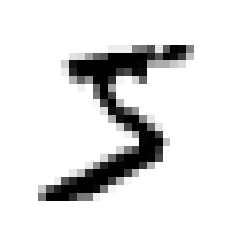

In [3]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

first_data = X[0]
first_image_data = first_data.reshape(28, 28)

plt.imshow(first_image_data, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [7]:
import numpy as np

#문자열을 숫자로 변환
y = y.astype(np.uint8)
y[0]

5

# 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들어 놔야 한다.

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 5와 5가 아닌 숫자를 분류하는 이진 분류기

In [9]:
y_train_5 = (y_train == 5) #5인 숫자만 true, 나머지는 false
y_test_5 = (y_test == 5)

확률적 강사하강법(SGD)는 온라인 학습에 잘 맞는다.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([first_data])

array([ True])

교차검증을 이용한 정확도 측정

In [13]:
from sklearn.model_selection import StratifiedKFold #클래스별 비율이 유지되도록 계측정 샘플링을 통해 폴드 생성
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold) #True는 1이고, False는 0으로 취급
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

무조건 5가 아닌 것으로 분류하는 가짜 분류기

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

#이미지의 10%가 5이기 때문에 무조건 5가 아님으로 분류해도 정확도는 90%

array([0.91125, 0.90855, 0.90915])

분류기의 성능은 정확도 보다는 오차 행렬을 더 좋은 방법

주의 할 점은 테스트 세트는 분류기가 출시 준비를 마치고 나서 프로젝트의 맨 마지막에 사용된다

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

#첫번째 행은 '5아님'(음성), 687개는 5라고 잘못 분류한 것
#둘째 행은 '5'(양성), 1891개를 '5아님'으로 잘 못 분류

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [20]:
#완벽한 분류기의 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

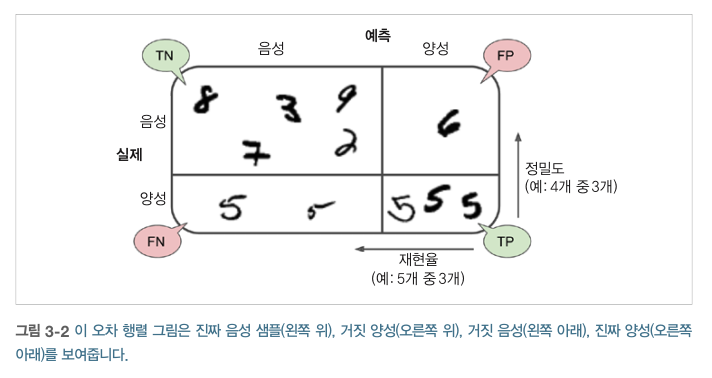

In [23]:
from sklearn.metrics import precision_score, recall_score

#정밀도(5로 판별된 이미지 중에 83.7%만 정확)
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
#재현율(정확하게 감지한 양성 샘플의 비율)
#전체 숫자 5중에서 65%만 감지
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [25]:
#정밀도와 재현율의 조화 평균
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

# 정밀도와 재현율은 트레이드오프 관계에 있다.

In [26]:
#샘플의 점수 확인
y_scores = sgd_clf.decision_function([first_data])
y_scores

array([2164.22030239])

In [28]:
#SGDClassifier의 임계값은 0
threshold = 0
y_first_data_pred = (y_scores > threshold)
y_first_data_pred

array([ True])

In [29]:
#임계값을 높이면
threshold = 8000
y_first_data_pred = (y_scores > threshold)
y_first_data_pred

array([False])

In [30]:
#적절한 임계값을 정하기 위해서는 먼저 훈련세트의 모든 샘플의 점수를 구해야 한다.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [48]:
print(len(precisions))
print(len(precisions[:-1]))
print(precisions)
print(precisions.shape)
print(np.argmax(precisions)) #최대값의 인덱스
print(precisions[np.argmax(precisions)])
print(np.argmax(precisions >= 0.90)) #0.90이상인 값들 중 최대값의 인덱스
print(precisions[np.argmax(precisions >= 0.90)])
print(np.max(precisions))

print(precisions >= 0.90)

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
print(recall_90_precision)

59967
59966
[0.09040123 0.09038606 0.09038757 ... 1.         1.         1.        ]
(59967,)
59961
1.0
57075
0.9000345901072293
1.0
[False False False ...  True  True  True]
3370.0194991439557
0.4799852425751706


In [42]:
import os

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

그림 저장: precision_recall_vs_threshold_plot


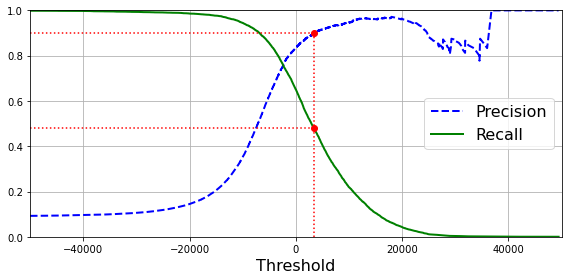

In [47]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] #0.90이상인 것들이 False...., True로 변환해서 첫번째 True의 인덱스
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:") #x:3370~3370, y:0~0.9
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:") #x:-50000~3370, y: 0.9~0.9
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:") #x:-50000~3370, y:0.48~0.48
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

그림 저장: precision_vs_recall_plot


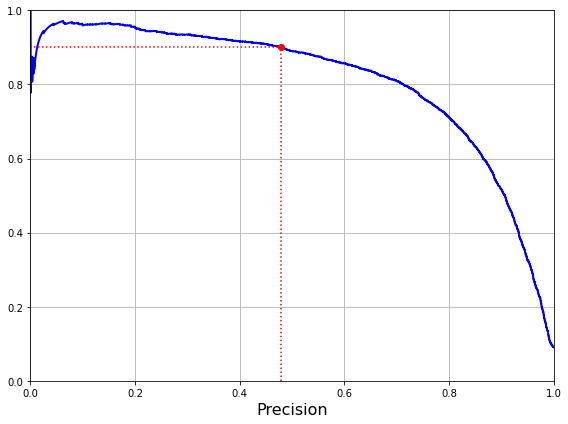

In [51]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.xlabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1]) #x축최소, x축최대, y축최소, y축최대
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.48, 0.48], [0., 0.9], "r:")
plt.plot([0.0, 0.48], [0.9, 0.9], "r:")
plt.plot([0.48], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

#재현율 80% 근처에서 정밀도가 급감
#예를 들면 재현율 60% 정도인 지점을 트레이드오프로 선택

In [52]:
#만약 정밀도 90%가 목표라면
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [53]:
#90% 정밀도를 갖는 임계값으로 점수 확인
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [54]:
#정밀도와 재현율 확인
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

#정밀도는 높지만 재현율이 너무 낮은 분류기는 유용하지 않다.

0.9000345901072293
0.4799852425751706


# 수신기 조작 특성(ROC) 곡선 - 이진분류에서 널리 사용

In [55]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


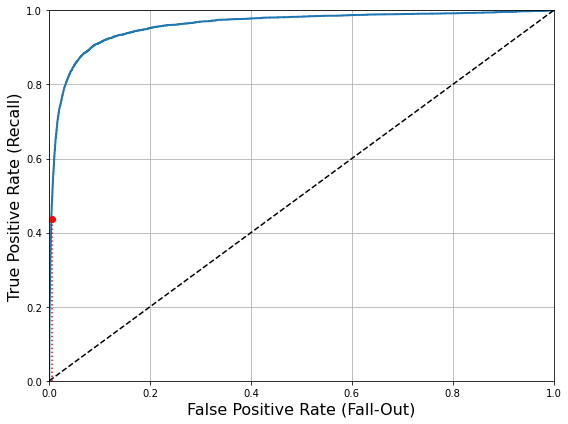

In [56]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

#재현율이 높을 수록 거짓양성(FPR)이 늘어난다.

In [64]:
from sklearn.metrics import roc_auc_score

#곡선 아래 면적(AUC)
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [57]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

In [59]:
print(y_probas_forest)
print(y_probas_forest[:, 1])#음성, 양성에서 양성관련 열만을 사용

[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 ...
 [0.02 0.98]
 [0.92 0.08]
 [0.94 0.06]]
[0.89 0.01 0.04 ... 0.98 0.08 0.06]


In [60]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

그림 저장: roc_curve_comparison_plot


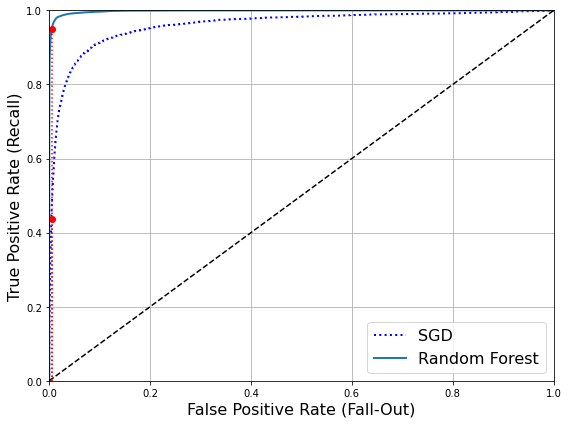

In [61]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [65]:
#곡선 아래 면적(AUC)
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [63]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9905083315756169
0.8662608374838591


# 다중 분류

In [66]:
from sklearn.svm import SVC
svm_clf = SVC()
#OvO전략으로 다중분류 훈련
svm_clf.fit(X_train, y_train)
svm_clf.predict([first_data])

#이진 분류 알고리즘은 SVM에 대해 다중 분류를 시행하면 자동으로 OvO, OvR(one versus the rest)전략으로 다중 분류 수행

array([5], dtype=uint8)

In [67]:
first_data_scores = svm_clf.decision_function([first_data])
first_data_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [68]:
np.argmax(first_data_scores)

5

In [69]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [70]:
#SGD 분류기는 직접 다중 분류가 가능하므로 OvO, OvR 적용 할 필요 없음.
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([first_data])

#오답이구마...-_-

array([3], dtype=uint8)

In [71]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

#3번의 시행에서 얻은 각각의 정확도

array([0.87365, 0.85835, 0.8689 ])

In [72]:
#입력 스케일 조정하여 정확도 높이기

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 에러 분석

In [73]:
#먼저 오차 행렬 살펴보기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

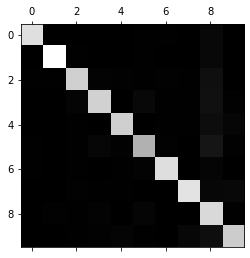

In [74]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [75]:
#에러 비율 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

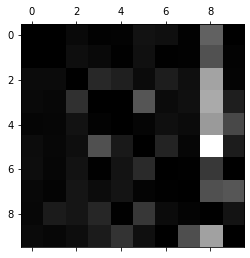

In [76]:
#좌측 상단에서 아래쪽으로 대각선 방향으로 0으로 채우기(자기 자신에 대한 분류 삭제)
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#행은 실제 클래스, 열은 예측한 클래스
#많은 이미지가 8로 잘못 분류되었음
#하지만 8행을 보면 다른 이미지로 잘못 분류된 케이스가 적음

In [77]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

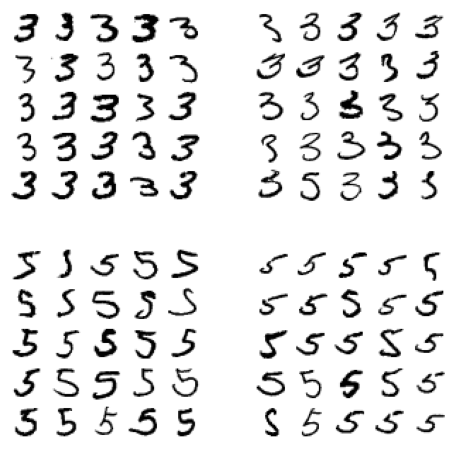

In [79]:
#3, 5샘플 확인
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) # 3->3 분류
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5) # 3->5분류
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5) # 5->3분류
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5) # 5->5분류
plt.show()

#좌측 상단 : 3 -> 3 분류
#좌측 하단 : 5 -> 3 분류
#우측 상단 : 3 -> 5 분류
#우측 하단 : 5 -> 5 분류

# 다중 레이블 분류

In [80]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
#두 개의 타게 레이블(7이상인가, 홀수인가)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [81]:
knn_clf.predict([first_data])

array([[False,  True]])

In [82]:
#다중 레이블 분류기 평가
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

#모든 레이블의 가중치가 같다고 가정
#가중치를 주려면, average="weighted"

0.976410265560605

# 다중 출력 분류

In [84]:
np.random.seed(42)

#원본 이미지에 노이즈 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

#원본 이미지가 테스트 세트로
y_train_mod = X_train
y_test_mod = X_test

In [86]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

그림 저장: noisy_digit_example_plot


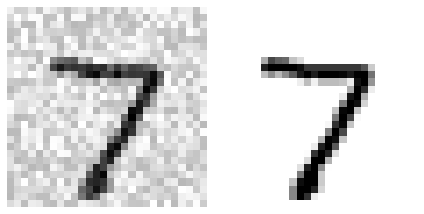

In [87]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

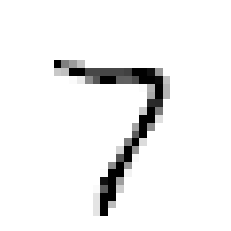

In [89]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# 연습문제 1 - 97%정확도의 MNIST 분류기

k-neighbors 분류기에 대한 간략한 설명(https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657)
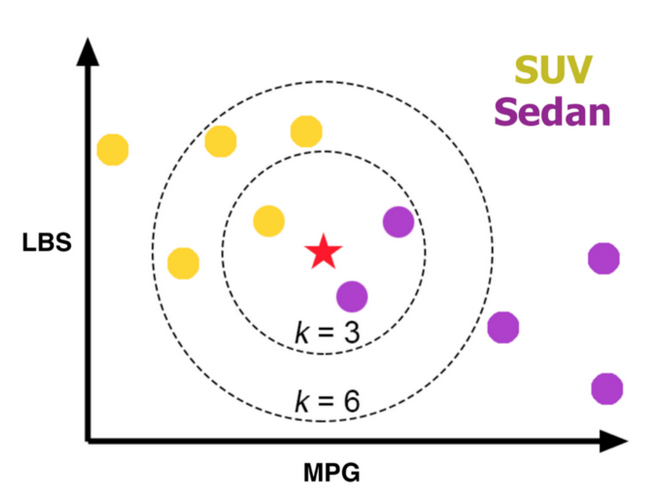
x축이 연비, y축이 차량 무게 라고 했을 때,
별이 예측하고자 하는 데이터.
k값은(n_neighbor) 몇 개의 값을 포함하여 예측을 할 것인지를 나타냄.
k가 3일때와 6일 때 예측값이 달라짐

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [
    {
        'weights': [
            "uniform", #k안에 포함되는 이웃들이 모두 같은 가중치를 갖도록
            "distance" #가까운 점이 더 높은 가중치를 갖도록
        ], 
        'n_neighbors': [3, 4, 5] #결정에 포함될 이웃의 값
    }
]

knn_clf = KNeighborsClassifier()
#그리고 서치로 최적의 하이퍼파라미터 찾기
grid_search = GridSearchCV(
    knn_clf, param_grid, cv=5, verbose=3,
    n_jobs = 10 #모든 프로세서를 활용하도록
) 

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 out of  30 | elapsed: 56.6min remaining: 20.6min
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed: 56.7min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=10,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

[CV] n_neighbors=3, weights=distance .................................

[CV] n_neighbors=3, weights=uniform ..................................

[CV] n_neighbors=3, weights=uniform ..................................

[CV] n_neighbors=3, weights=uniform ..................................

[CV] n_neighbors=3, weights=distance .................................

[CV] n_neighbors=3, weights=distance .................................

[CV] n_neighbors=3, weights=uniform ..................................

[CV] n_neighbors=3, weights=uniform ..................................

[CV] n_neighbors=3, weights=distance .................................

[CV] n_neighbors=3, weights=distance .................................

[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=18.4min

[CV] n_neighbors=4, weights=uniform ..................................

[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=18.4min

[CV] n_neighbors=4, weights=uniform ..................................

[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=18.4min

[CV] n_neighbors=4, weights=uniform ..................................

[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=18.4min

[CV] ..... n_neighbors=3, weights=distance, score=0.971, total=18.4min

[CV] n_neighbors=4, weights=uniform ..................................

[CV] n_neighbors=4, weights=uniform ..................................

[CV] ...... n_neighbors=3, weights=uniform, score=0.970, total=18.4min

[CV] n_neighbors=4, weights=distance .................................

[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=18.5min

[CV] n_neighbors=4, weights=distance .................................

[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=18.5min

[CV] n_neighbors=4, weights=distance .................................

[CV] ...... n_neighbors=3, weights=uniform, score=0.972, total=18.5min

[CV] n_neighbors=4, weights=distance .................................

[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=18.5min

[CV] n_neighbors=4, weights=distance .................................

[CV] ...... n_neighbors=4, weights=uniform, score=0.968, total=19.0min

[CV] n_neighbors=5, weights=uniform ..................................

[CV] ...... n_neighbors=4, weights=uniform, score=0.969, total=19.1min

[CV] n_neighbors=5, weights=uniform ..................................

[CV] ..... n_neighbors=4, weights=distance, score=0.973, total=19.0min

[CV] n_neighbors=5, weights=uniform ..................................

[CV] ...... n_neighbors=4, weights=uniform, score=0.967, total=19.0min

[CV] n_neighbors=5, weights=uniform ..................................

[CV] ..... n_neighbors=4, weights=distance, score=0.970, total=19.0min

[CV] n_neighbors=5, weights=uniform ..................................

[CV] ...... n_neighbors=4, weights=uniform, score=0.968, total=19.0min

[CV] n_neighbors=5, weights=distance .................................

[CV] ...... n_neighbors=4, weights=uniform, score=0.970, total=19.1min

[CV] n_neighbors=5, weights=distance .................................

[CV] ..... n_neighbors=4, weights=distance, score=0.971, total=19.0min

[CV] n_neighbors=5, weights=distance .................................

[CV] ..... n_neighbors=4, weights=distance, score=0.972, total=19.1min

[CV] n_neighbors=5, weights=distance .................................

[CV] ..... n_neighbors=4, weights=distance, score=0.972, total=19.1min

[CV] n_neighbors=5, weights=distance .................................

[CV] ...... n_neighbors=5, weights=uniform, score=0.970, total=19.2min

[CV] ..... n_neighbors=5, weights=distance, score=0.970, total=19.2min

[CV] ...... n_neighbors=5, weights=uniform, score=0.970, total=19.2min

[CV] ...... n_neighbors=5, weights=uniform, score=0.968, total=19.2min

[CV] ..... n_neighbors=5, weights=distance, score=0.970, total=19.2min

[CV] ...... n_neighbors=5, weights=uniform, score=0.969, total=19.2min

[CV] ..... n_neighbors=5, weights=distance, score=0.971, total=19.2min

[CV] ...... n_neighbors=5, weights=uniform, score=0.969, total=19.2min

[CV] ..... n_neighbors=5, weights=distance, score=0.971, total=19.1min

[CV] ..... n_neighbors=5, weights=distance, score=0.969, total=19.1min

In [11]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [13]:
grid_search.best_score_

0.9716166666666666

In [14]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

# 2.데이터 증식

In [4]:
from scipy.ndimage.interpolation import shift

In [5]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape(-1)

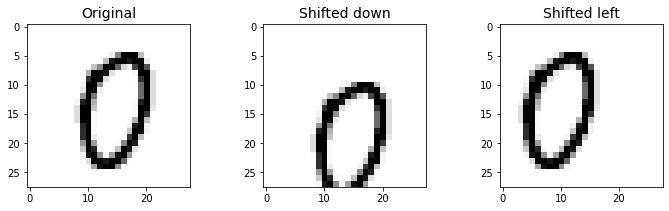

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

#X_train은 (60000, 784)로 각 행마다 28*28 이미지 포함
image = X_train[1000] #1000번째 행에 위치한 이미지
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [7]:
import numpy as np

#각 행의 데이터를 배열로 추출
#각 행에서 추출데이터 배열로 구성된 배열을 만들기
X_train_augmented = []
y_train_augmented = []

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

In [8]:
print(len(X_train_augmented))
a = np.array(X_train_augmented)
print(a.shape)
b = np.vstack([X_train, a])
print(b.shape)

print(len(y_train_augmented))
a = np.array(y_train_augmented)
print(a.shape)
print(y_train.shape)
b = np.hstack([y_train, a])
print(b.shape)

X_train_augmented = np.array(X_train_augmented)
#hstack은 좌우로 이어붙이기(행의 개수가 같아야 함)
#vstack은 위아래로 이어붙이기(열의 개수가 같아야 함)
X_train_augmented = np.vstack([X_train, X_train_augmented])
y_train_augmented = np.array(y_train_augmented)
y_train_augmented = np.hstack([y_train, y_train_augmented])

240000
(240000, 784)
(300000, 784)
240000
(240000,)
(60000,)
(300000,)


In [9]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx] #랜덤한 인덱스로 섞기
y_train_augmented = y_train_augmented[shuffle_idx] #랜덤한 인덱스로 섞기

In [15]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier()

In [16]:
from sklearn.metrics import accuracy_score

y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9754

# 타이타닉 데이터셋 도전

In [43]:
import os
TITANIC_PATH = os.path.join("datasets", "titanic")

In [44]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [45]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [46]:
#테스트 데이터로 모델 훈련을 해야 하지만 테스트 데이터에는 레이블이 없음.
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



    Survived: 타깃입니다. 0은 생존하지 못한 것이고 1은 생존을 의미합니다.
    Pclass: 승객 등급. 1, 2, 3등석.
    Name, Sex, Age: 이름 그대로 의미입니다.
    SibSp: 함께 탑승한 형제, 배우자의 수.
    Parch: 함께 탑승한 자녀, 부모의 수.
    Ticket: 티켓 아이디
    Fare: 티켓 요금 (파운드)
    Cabin: 객실 번호
    Embarked: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)


In [47]:
#누락된 데이터 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


cabin은 null비율이 높으므로 무시, age는 null값에 대해 중간값을 활용.

name, ticket경우 값은 다 있지만, 머신러닝 모델이 사용할 수 있는 숫자로 변환하기 어려우므로 무시

In [48]:
#통계치
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


생존율은 38%

평균 나이는 29.7세

In [49]:
#타겟 값이 0과 1인지 확인
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [50]:
#범주형 특성 확인
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [51]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [52]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Pipeline을 통해 각 열을 다른게 전처리

In [53]:
#전 처리 파이프라인 만들기
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [54]:
#숫자 특성을 위한 파이프라인
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("select_numberic", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median")) #누락된 값을 특성의 중간값으로 대체
])

In [55]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [58]:
print(train_data["Embarked"].value_counts())
print(train_data["Embarked"].value_counts().index)
print(train_data["Embarked"].value_counts().index[0]) #가장 많이 등장한 값
pd.Series([train_data[c].value_counts().index[0] for c in train_data],
                                       index = train_data.columns) #모든 컬럼에 대해서 가장 많이 등장한 값들

S    644
C    168
Q     77
Name: Embarked, dtype: int64
Index(['S', 'C', 'Q'], dtype='object')
S


PassengerId                        891
Survived                             0
Pclass                               3
Name           Turja, Miss. Anna Sofia
Sex                               male
Age                                 24
SibSp                                0
Parch                                0
Ticket                          347082
Fare                              8.05
Cabin                          B96 B98
Embarked                             S
dtype: object

In [65]:
#문자열 범주형 열을 위한 Imputer클래스
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index = X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [60]:
from sklearn.preprocessing import OneHotEncoder

In [66]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [67]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [68]:
#숫자형 + 범주형 파이프라인
from sklearn.pipeline import FeatureUnion

preprocessing_pipeline = FeatureUnion(
    transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ]
)

In [69]:
X_train = preprocessing_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [70]:
#테스트 데이터의 레이블 가져오기
y_train = train_data["Survived"]

SVC사용하여 분류기 훈련

In [71]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [72]:
X_test = preprocessing_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [74]:
#교차 검증으로 확인하기
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)#, n_jobs=10)
svm_scores.mean()

0.7329588014981274

In [75]:
#정확도를 높이기 위해 랜덤 포레스트 적용

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

상자-수염-그림(https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/box-plot-review)
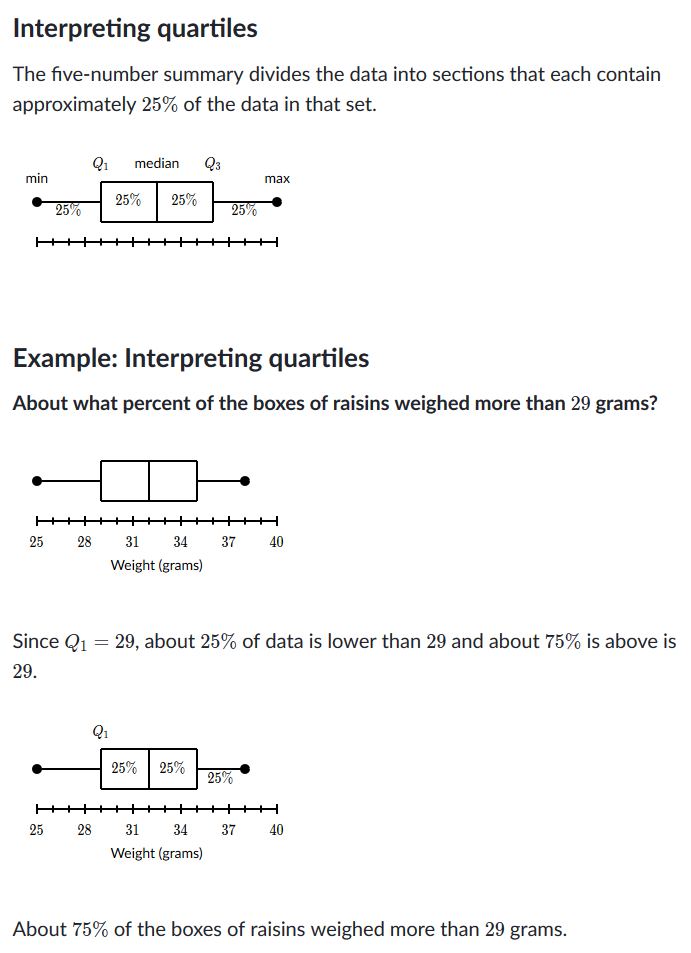

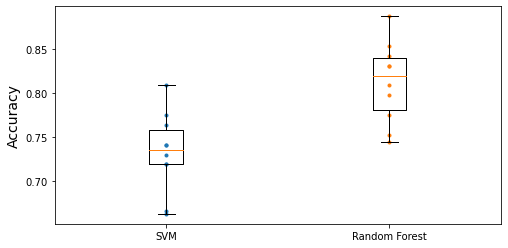

In [76]:
plt.figure(figsize=(8,4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

더 향상시키려면 교차 검증 및 그리드 탐색을 통해 하이퍼파라미터 튜닝

특성공학 - Survived 특성과 관련됨 이름(Countess가 있다던지)

수치 특성을 범주형 특성으로 변경 - 나이대가 다른 경우 다른 생존 비율을 가질 수 있다

혼자 여행 하는 사람과 관련된 범주

In [78]:
#나이대에 따른 생존 비율

train_data["AgeBucket"] = train_data["Age"] // 15 * 15 #소수점 데이터 없애기
train_data[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [79]:
train_data["RelativeOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativeOnboard", "Survived"]].groupby(["RelativeOnboard"]).mean()

,Survived
RelativeOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [82]:
#추가한 범주를 포함하여 처리
num_pipeline = Pipeline([
    ("select_numberic", DataFrameSelector(["AgeBucket", "RelativeOnboard", "Fare"])),
    ("imputer", SimpleImputer(strategy="median")) #누락된 값을 특성의 중간값으로 대체
])

preprocessing_pipeline = FeatureUnion(
    transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ]
)

X_train = preprocessing_pipeline.fit_transform(train_data)
#테스트 데이터의 레이블 가져오기
y_train = train_data["Survived"]

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores2 = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores2.mean()

0.8159925093632958

# 스팸 필터

In [1]:
#스팸 데이터 다운로드

import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [2]:
fetch_spam_data()

In [6]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
#맨 마지막에 위치한 cmds파일을 제외하기 위함
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [7]:
len(ham_filenames)

2500

In [8]:
len(spam_filenames)

500

이메일 파싱하기

In [67]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [68]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

햄 메일과 스팸 메일 내용 확인

In [69]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [70]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


첨부 파일을 가진 이메일도 있음

In [71]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(",".join(
            [
                get_email_structure(sub_email)
                for sub_email in payload
            ]
        ))
    else:
        return email.get_content_type()    

In [72]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [73]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain,application/pgp-signature)', 66),
 ('multipart(text/plain,text/html)', 8),
 ('multipart(text/plain,text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain,application/octet-stream)', 2),
 ('multipart(text/plain,text/enriched)', 1),
 ('multipart(text/plain,application/ms-tnef,text/plain)', 1),
 ('multipart(multipart(text/plain,text/plain,text/plain),application/pgp-signature)',
  1),
 ('multipart(text/plain,video/mng)', 1),
 ('multipart(text/plain,multipart(text/plain))', 1),
 ('multipart(text/plain,application/x-pkcs7-signature)', 1),
 ('multipart(text/plain,multipart(text/plain,text/plain),text/rfc822-headers)',
  1),
 ('multipart(text/plain,multipart(text/plain,text/plain),multipart(multipart(text/plain,application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain,application/x-java-applet)', 1)]

In [74]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain,text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain,image/jpeg)', 3),
 ('multipart(text/html,application/octet-stream)', 2),
 ('multipart(text/plain,application/octet-stream)', 1),
 ('multipart(text/html,text/plain)', 1),
 ('multipart(multipart(text/html),application/octet-stream,image/jpeg)', 1),
 ('multipart(multipart(text/plain,text/html),image/gif)', 1),
 ('multipart/alternative', 1)]

햄 메일은 평범한 텍스트인 경우가 많고, 스팸은 HTML이 많다.

이메일 구조는 스팸 구분에 유용한 정보

이메일 헤더를 살펴볼 차례

In [75]:
for header, value in spam_emails[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

유용한 정보가 많지만, 제목만을 다뤄보자

In [76]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

데이터를 더 살펴보기 전에 훈련 세트와 테스트 세트로 구분

In [77]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

전 처리 함수를 작성할 차례

HTML -> 일반텍스트

BeautifulSoup이 적합하나 정규식으로 대강 처리

In [78]:
#<head>를 삭제하고, 모든 <a>태그를 'HYPERLINK'로 바꾸기
#모든 HTML태그를 삭제하고 텍스트만 남긴다.

import re
from html import unescape

def html_to_plain_text(html):
    #re.M = Multiline , re.S = dot matches all , re.I = ignore case
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I) 
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

정규식 기호(https://python.bakyeono.net/chapter-11-2.html)

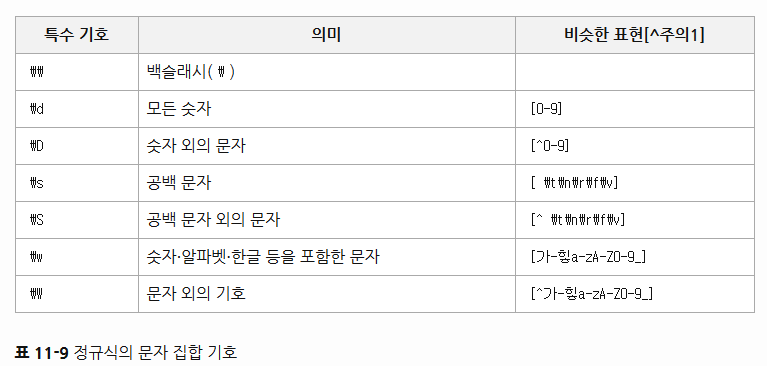

In [79]:
html_spam_emails = [email for email in X_train[y_train==1]
                 if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [80]:
print(html_to_plain_text(sample_html_spam.get_content().strip())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

포맷에 상관없이 이메일을 받아서 일반 텍스트를 출력하는 함수

In [81]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: #인코딩 문제가 있는 경우
            content = str(part.get_payload())
        
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [82]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


어간 추출 : 어간은 단어의 개념적 의미를 나타내는 변하지 않는 부분.
    
nltk를 설치해야 함.

In [83]:
try:
    import nltk
    
    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("nltk를 설치하세요")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


인터넷 주소를 "URL"로 변경하기 위해서 urlextract 설치 필요

In [84]:
try:
    import urlextract
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("urlextract를 설치하세요")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


하나의 변환기로 연결해서 이메일을 단어 카운트로 변환

여기서는 split()을 사용하여 구두점(쉼표, 마침표)과 빈칸 기준으로 문장을 단어로 변환

(일본어 등의 공백이 없는 언어에서는 통하지 않음)

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin

#punctuation = 구두점
class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or "" #리턴값이 없는 경우 ""로 처리
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text))) #중복 되는 걸 없애기 위해서 set변환 후 다시 리스트로
                urls.sort(key=lambda url: len(url), reverse=True) #url길이 역순으로 정렬
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M) #\W : 문자 이외의 기호, re.M = multiline
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [86]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

단어 카운트를 벡터로 변환해야 하므로, 변환기 작성

In [87]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common = most_common
        self.vocabulary_ = {
            word: index + 1 for index, (word, count) in enumerate(most_common)
        }
        return self
    
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [88]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 20 stored elements in Compressed Sparse Row format>

In [89]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]], dtype=int32)

In [90]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

위 행렬에서 첫번째 열은 어휘 목록에 없는 단어 개수

그리고 차례대로 어휘 목록의 단어가 몇 번 등장하는지

In [91]:
#전체 데이터 셋 변환

from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline(
[
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer())
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3, n_jobs=6)
score.mean()

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    0.4s finished


0.9862500000000001

In [93]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("정밀도: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("재현율: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

정밀도: 93.94%
재현율: 97.89%


c:\sources\python\deeplearning\dl\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
